#Anomaly Detection in Credit Card Transactions 
---

## Project Goal
In this project, we evaluate an imbalanced dataset of credit card frauds (with the target labels being authentic and fraudulent) and build an anomaly detection system to identify transactions that somewhat vary from the typical, authentic transactions. These observations are flagged as potentially fraudulent and put to further validation.

An anomaly is a rare observation that deviates significantly from most data and does not conform to the notion of normal behaviour. Such observations may have been induced by a distinct mechanism or appear inconsistent with the remainder of the dataset. 

Anomaly detection can be beneficial in credit card fraud detection. Fraudulent transactions are rare compared to authentic transactions. Also, the methods through which fraudulent transactions occur keep evolving, as the old ways get flagged by existing fraud detection systems. Here, we will develop an anomaly detection system that flags transactions with characteristic values deviating significantly from authentic transactions.

###I. Setups and Imports



In [1]:

import time, psutil, os, gc
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot


from sklearn.model_selection import train_test_split
from tqdm.contrib import itertools


###II. Installing Processing the Dataset
Source: https://www.kaggle.com/mlg-ulb/creditcardfraud


---

The dataset consists of information on the transactions made using credit cards by European cardholders on two particular days in September 2013. It presents a total of 284807 transactions, of which 492 were fraudulent. The dataset is highly imbalanced, with the fraudulent transactions accounting for only 0.173% of all transactions.


In [6]:
from google.colab import files
 
 
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [7]:
# Loading the data
data = pd.read_csv('creditcard.csv')

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###III. Training-Test-Validation Split 


In [64]:
# Splitting the data by target class
data_authentic,data_fraudulent  = data[data['Class'] == 0], data[data['Class'] == 1]

# Feature-target split
x_0, y_0 = data_authentic.drop('Class', axis = 1), data_authentic['Class']
x_1, y_1 = data_fraudulent.drop('Class', axis = 1), data_fraudulent['Class']

# Splitting the authentic class into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x_0, y_0, test_size = 0.2, random_state = 40)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 40)
data_val_1, data_test_1 = pd.concat([x_val, y_val], axis = 1), pd.concat([x_test, y_test], axis = 1)

# Splitting the fraudulent class into testing and training sets
x_val, x_test, y_val, y_test = train_test_split(x_1, y_1, test_size = 0.5, random_state = 40)
data_val_2, data_test_2 = pd.concat([x_val, y_val], axis = 1), pd.concat([x_test, y_test], axis = 1)

# Merging the data to construct the validation set and the test set
data_val, data_test = pd.concat([data_val_1, data_val_2], axis = 0), pd.concat([data_test_1, data_test_2], axis = 0)
x_val, y_val = data_val.drop('Class', axis = 1), data_val['Class']
x_test, y_test = data_test.drop('Class', axis = 1), data_test['Class']

In [65]:
# Distribution of authentic and fraudulent transactions over training, validation and test set
labels = ['Train', 'Validation', 'Test']
values_0 = [len(y_train[y_train == 0]), len(y_val[y_val == 0]), len(y_test[y_test == 0])]
values_1 = [len(y_train[y_train == 1]), len(y_val[y_val == 1]), len(y_test[y_test == 1])]

fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(values = values_0, labels = labels, hole = 0.5, textinfo = 'percent', title = "Authentic"),row = 1, col = 1)
fig.add_trace(go.Pie(values = values_1, labels = labels, hole = 0.5, textinfo = 'percent', title = "Fraudulent"),row = 1, col = 2)
fig.update_layout(height = 500, width = 800, showlegend = True) 
fig.show()

###IV. Feature Engineering
---


*   Amount: The distribution of the amount has extreme skewness. We apply the transformation x↦log(x+0.001) to this column to deal with the zero-amount transactions, which leads to log0, an indefinite quantity.




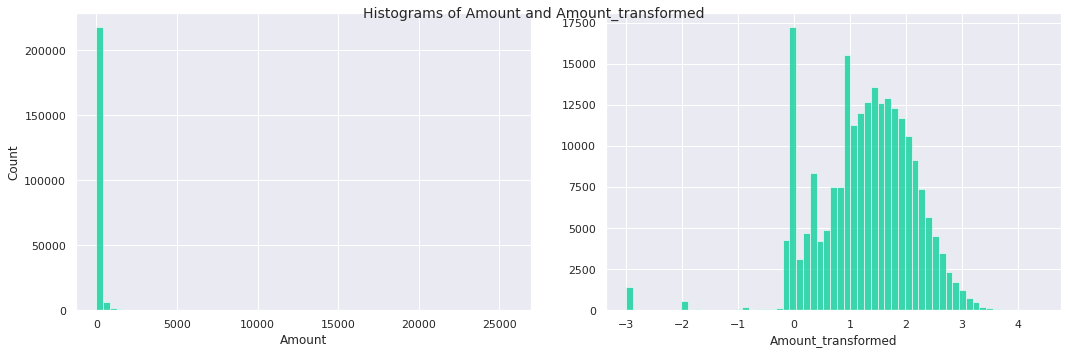

In [70]:
# Transformation of 'Amount'
bins_train = math.floor(len(x_train)**(1/3))
for df in [x_train, x_val, x_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)
# Visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = False)
sns.histplot(data = x_train, x = 'Amount', bins = bins_train, ax = ax[0], color='#00CE96')
sns.histplot(data = x_train, x = 'Amount_transformed', bins = bins_train, ax = ax[1], color='#00CE96')
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Amount and Amount_transformed", size = 14)
plt.tight_layout()
plt.show()



*   Time: The distribution over hours seem to be in therange 9- 23 i.e, between 9 a.m. and 11 p.m.



In [71]:

for df in [x_train,x_val, x_test]:
    df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
    df['Hour'], temp = temp // (60*60), temp % (60*60)
    df['Minute'], df['Second'] = temp // 60, temp % 60
x_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()

,Time,Day,Hour,Minute,Second
19594,30401.0,0.0,8.0,26.0,41.0
124712,77397.0,0.0,21.0,29.0,57.0
167920,118964.0,1.0,9.0,2.0,44.0
47377,43191.0,0.0,11.0,59.0,51.0
41731,40804.0,0.0,11.0,20.0,4.0


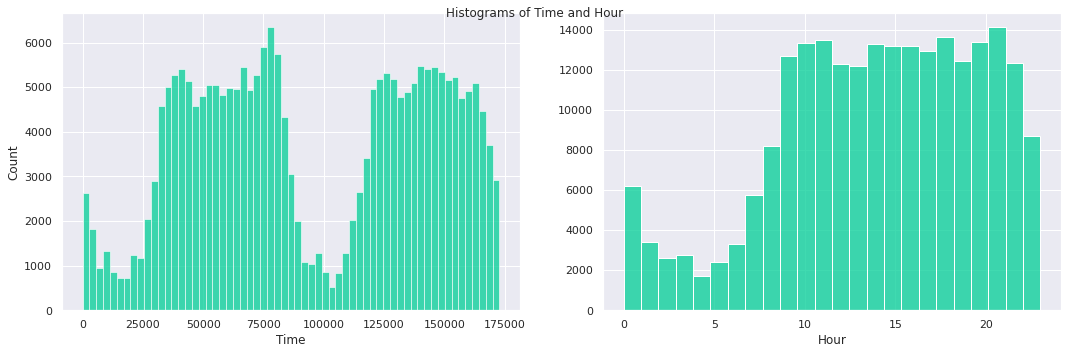

In [72]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = False)

p1=sns.histplot(data = x_train, x = 'Time', bins = bins_train, ax = ax[0], color='#00CE96')
p2=sns.histplot(data = x_train, x = 'Hour', bins = 24, ax = ax[1], color='#00CE96')
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size = 12)
plt.tight_layout()
plt.show()

In [73]:
for df in [x_train, x_val, x_test]:
    df.drop(['Time', 'Day', 'Minute', 'Second', 'Amount'], axis = 1, inplace = True)

###V. Feature Selectiom
---
This dataset consists of 30 features. We aim to utilize only those which substantially help discriminate between authentic and fraudulent transactions. More specifically, we compare the distribution of each feature for both the target classes. If a feature has similar distributions for authentic and fraudulent transactions, then it is not likely to contribute much to classifying a transaction as authentic or fraudulent. However, if a feature has very different distributions for different target classes, it plays a far more significant role in the same process. Thus, the features exhibiting fairly distinct distributions across the target classes are chosen.

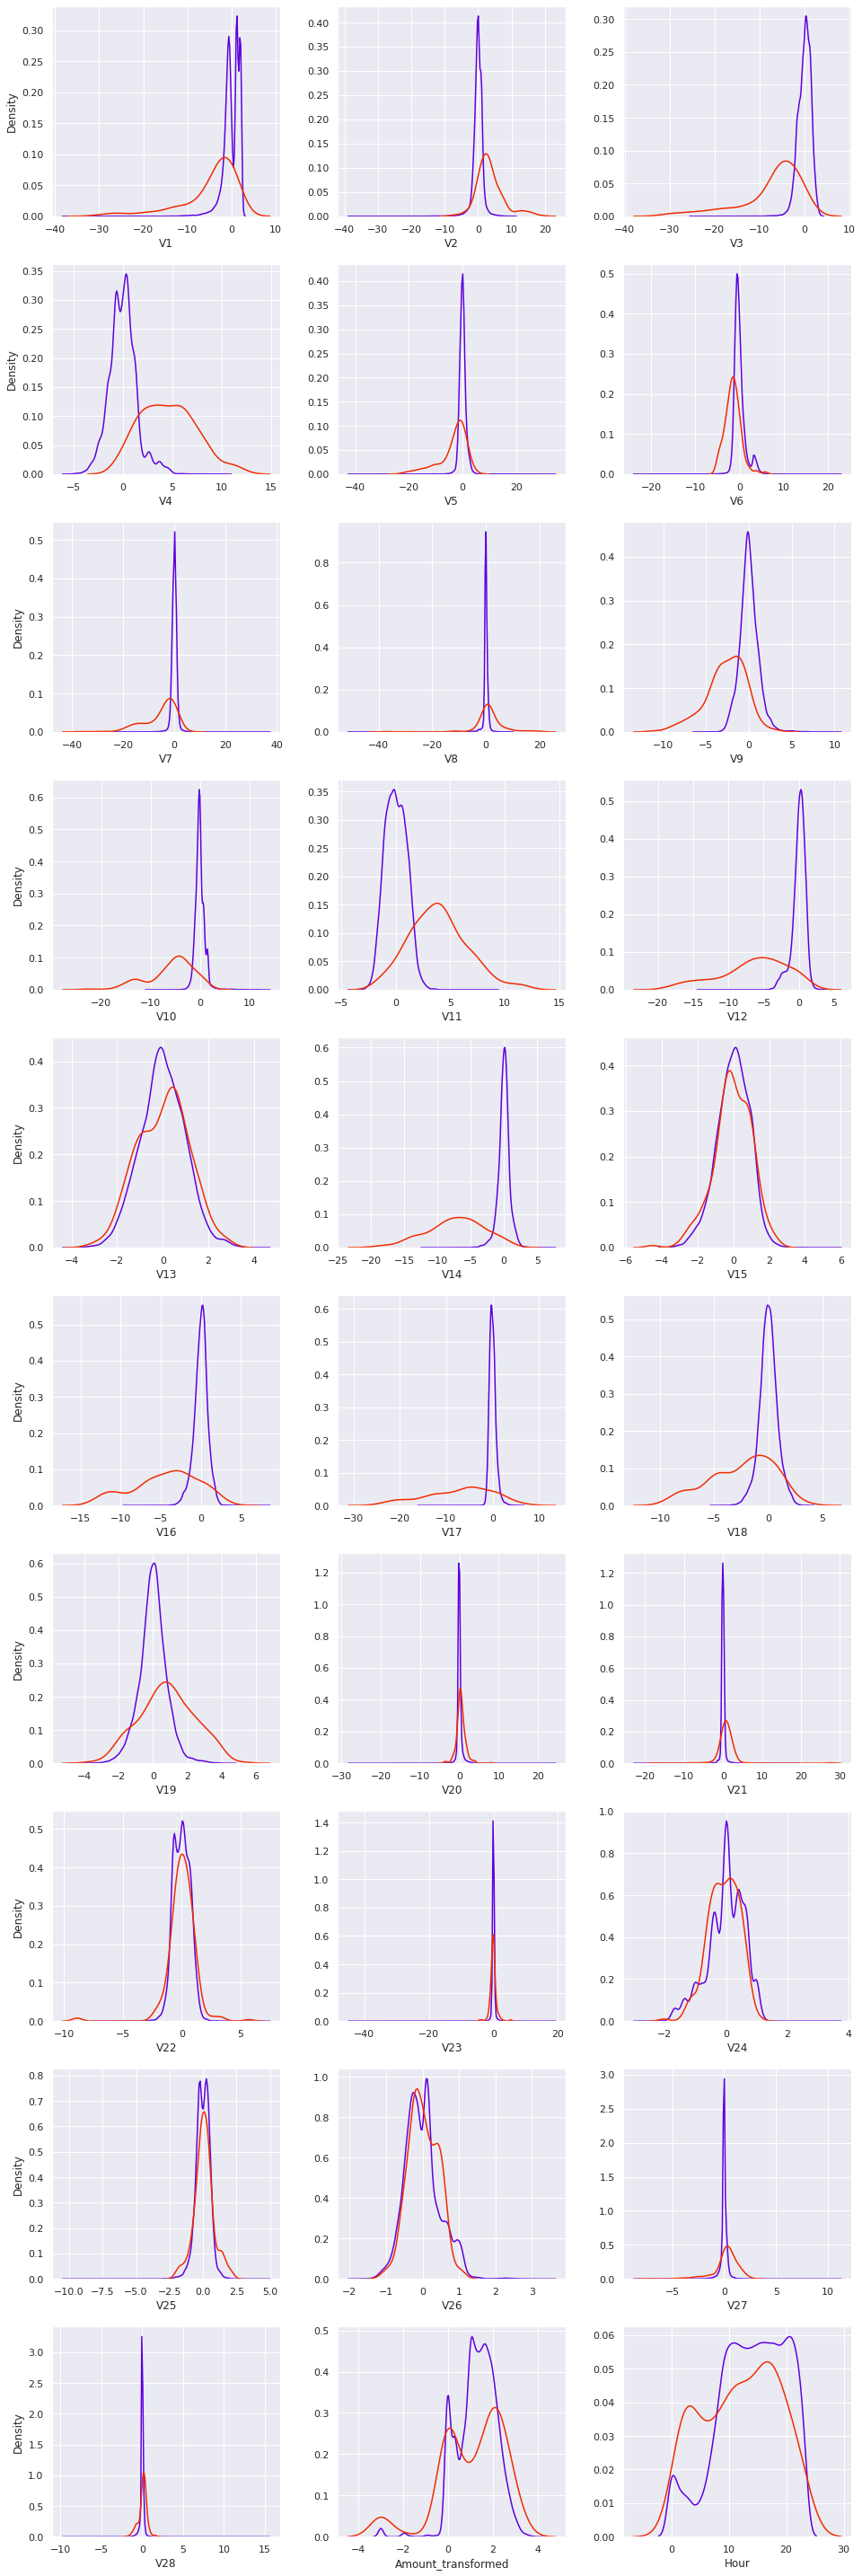

In [74]:
# Comparison of feature distributions for different target classes
data_val = pd.concat([x_val, y_val], axis = 1)
data_val_0, data_val_1 = data_val[data_val['Class'] == 0], data_val[data_val['Class'] == 1]
cols, ncols = list(x_val.columns), 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols], color='#5C00DD')
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols], color='#F12A00')
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

Based on the obtained plots, columns V4, V7, V11, V12, V16, V17, V18, V19 and Hour are selected.


In [75]:

cols = ['V4', 'V11', 'V7','V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
x_train_fs, x_val_fs, x_test_fs = x_train[cols], x_val[cols], x_test[cols]
x_train_fs.head()

,V4,V11,V7,V12,V14,V16,V17,V18,V19,Hour
19594,-0.706232,2.027925,-0.150871,0.535822,0.250769,0.773615,0.449717,-1.963208,0.613481,8.0
124712,1.474933,-1.154523,-2.005665,0.263527,0.316174,-1.029415,1.030772,-0.438839,0.529080,21.0
167920,4.840766,-2.242431,-3.415069,0.034829,-0.546349,-0.070375,1.033695,0.531801,1.215045,9.0
47377,0.565273,-0.157045,1.513640,-0.548790,0.419194,0.183518,-0.681323,0.911357,1.318132,11.0
41731,-0.428860,-0.580964,-0.077855,-0.609099,-0.187948,1.226723,0.104368,-0.995711,0.420557,11.0


###VI. Implementaion of the model
---


*   Probability density function (pdf): Computes univariate normal probability density function (pdf) with mean mu, standard deviation sigma. It takes the following arguments: 

1.      x : input observation
2.      mu : mean
3.     sigma : standard deviation (positive)

*   Pdf product function: Computes the product of such univariate normal densities or the joint pdf of a number of feature variables, each of which has a univariate normal distribution and is statistically independent of the other features. The inputs for this function are:

1.    X : vector of input observations
2.    MU : vector of means
3.    SIGMA : vector of standard deviations (positive)


In [76]:
# Normal pdf
def normal_density(x, mu, sigma):
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f
  
# Product of normal pdfs
def normal_product(X, MU, SIGMA):
  
    assert min(SIGMA) > 0, "Standard deviation cannot be negative"
    assert len(MU) == len(MU), "Length of mean vector does not match length of input vector"
    assert len(sigma_train) == len(X), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(X)):
        f = f * normal_density(X[i], MU[i], SIGMA[i])
    return f



*   Anomaly prediction based on PDF: Mean and standard deviations are estimated for the chosen features in the training and testing set. These estimates depict the joint probability density function of the features, which is used to detect anomalous observations.



In [77]:
# Model fitting
mu_train, sigma_train = x_train_fs.mean(), x_train_fs.std()
# Function to predict anomaly based on probability density threshold
def model_normal(X, epsilon):
    y = []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)
        y.append((prob_density < epsilon).astype(int))
    return y


###VII. Threshold Tuning on Validation set
---
Here, we construct some functions to compute and display the confusion matrix and to compute the  F2 -score, given the true labels and the predicted labels of the target.


Functions to compute and display confusion matrices pertaining to the evaluation of the outputs based on the results predicted by our model.

In [89]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

F-score function: Computes accuracy, given true and predicted binary (0 or 1) labels. Inputs:


1.   y_test : True binary labels
2.   y_pred : Predicted binary labels

In [79]:
# Function to compute and return f2_score
def f2_score(y_test, y_pred):
    
    confusion_mat = conf_mat(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    f2 = (5 * tp) / ((5 * tp) + (4 * fn) + fp)
    return f2



In [80]:
# Tuning the threshold of density value
alpha_list, f2_list, f2_max, alpha_opt, y_val_pred_opt = [], [], 0.0, 0.0, np.zeros(len(y_val))
for alpha, j in itertools.product(np.arange(0.001, 0.051, 0.001), range(1)):
    y_val_pred = model_normal(x_val_fs, epsilon = alpha**x_val_fs.shape[1])
    f2 = f2_score(y_val, y_val_pred)
    alpha_list.append(alpha)
    f2_list.append(f2)
    if f2 > f2_max:
        alpha_opt = alpha
        y_val_pred_opt = y_val_pred
        f2_max = f2

  0%|          | 0/50 [00:00<?, ?it/s]

Plotting F-score over alpha

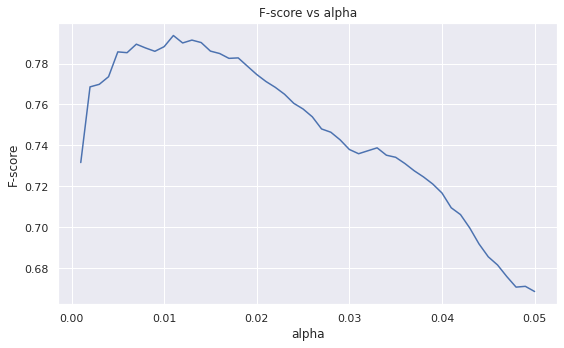

In [81]:
# Plotting F2-score over alpha
plt.figure(figsize = (8, 5))
plt.plot(alpha_list, f2_list)
plt.xlabel("alpha", fontsize = 12)
plt.ylabel("F-score", fontsize = 12)
plt.title("F-score vs alpha", fontsize = 12)
plt.tight_layout()
plt.show()

In [82]:

print(pd.Series({
    "Optimal alpha": alpha_opt,
    "Optimal F2-score": f2_score(y_val, y_val_pred_opt)
}).to_string())

Optimal alpha       0.011000
Optimal F2-score    0.793712


Confusion Matrix for predictions over validation datase.

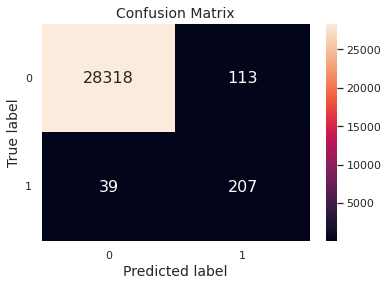

In [90]:

conf_mat_heatmap(y_val, y_val_pred_opt)

###VIII. Evaluation and Results for Test Dataset 

---



In [86]:
# Computing evaluation metrics
# Predicting Accuracy, Precision, F1-score, F2-score
def evaluation(test, pred):
    confusion_mat = conf_mat(test, pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    print(pd.Series({
        "Accuracy": (tp + tn) / (tn + fp + fn + tp),
        "Precision": tp / (tp + fp),
        "Recall": tp / (tp + fn),
        "F1-score": (2 * tp) / ((2 * tp) + fn + fp),
        "F2-score": (5 * tp) / ((5 * tp) + (4 * fn) + fp),
  
    }).to_string())


# Results for Test Dataset
y_test_normal = model_normal(x_test_fs, epsilon = alpha_opt ** x_test_fs.shape[1])
evaluation(y_test, y_test_normal)

Accuracy     0.994839
Precision    0.661184
Recall       0.817073
F1-score     0.730909
F2-score     0.780280


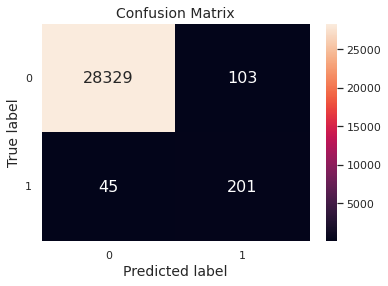

In [91]:
# Confusion matrix for Test Dataset
conf_mat_heatmap(y_test, y_test_normal)